In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc

sc.settings.n_jobs = 24

In [2]:
def shuffle(df):
    '''Shuffle a dataframe column-by-column.
    This ends up being a fast implementation of shuffling each column of a dataframe.
    Copied this function from Meng.
    '''
    index = df.index.values.tolist()
    index = index.copy()
    columns = df.columns.values.tolist()
    for i in columns:
        np.random.shuffle(index)
        temp = df.iloc[:,i].reindex(index).copy()
        temp.reset_index(drop=True,inplace=True)
        if i == 0:
            holding = (temp.values.copy(),)
        else:
            holding = holding+(temp.values.copy(),)
    holding = np.vstack(holding).transpose()
    holding = sc.AnnData(holding)
    return holding

def calculate_PC_variance_of_random_data(adata):
    '''Calculate the most significant PC variance of the adata with
    randomly shuffled columns.
    Adapted from Meng's code.
    '''
    # Repeat the random shuffling 10 times
    randomVariance = []
    for i in range(10):
        print(f'\tRandom shuffle trial {i}.')
        shuffled = shuffle(pd.DataFrame(adata.X))
        sc.tl.pca(shuffled,svd_solver = 'arpack')
        randomVariance.append(shuffled.uns['pca']['variance'][0])
    
    # Return the median of the random PC0 variances
    return np.median(randomVariance)

def embed_umap(original_adata, n_pcs=50, n_neighbors=15, metric='euclidean',
              min_dist=0.5, spread=1):
    '''Embed an adata using UMAP.
    Return a copy of the embeded adata.
    '''
    adata = original_adata.copy()
    
    # Principal component analysis
    if n_pcs == 'auto':
        print('Determine the number of PCs to use by random shuffling.')
        PC_var_threshold = calculate_PC_variance_of_random_data(adata)
        sc.tl.pca(adata, svd_solver='arpack', n_comps=200)
        n_pcs = len(adata.uns['pca']['variance'][adata.uns['pca']['variance'] > PC_var_threshold])
        print(f'Use {n_pcs} PCs.')
    else:
        sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)
    
    # Computing the neighborhood graph
    sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=n_neighbors, metric=metric)

    # Embed with UMAP
    sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    
    return adata

In [3]:
# Read the data
adata = sc.read_h5ad('/home/xingjie/ResearchProjects/cortical_development/published_sc_seq/Bella2021/adata.h5ad')

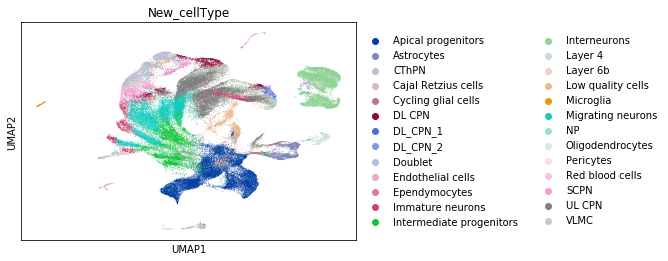

CPU times: user 1.07 s, sys: 120 ms, total: 1.19 s
Wall time: 1.05 s


In [4]:
%%time
# Plot the published UMAP
sc.pl.umap(adata, color='New_cellType')

In [5]:
#Preprocess the data
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Use 10 PCs:


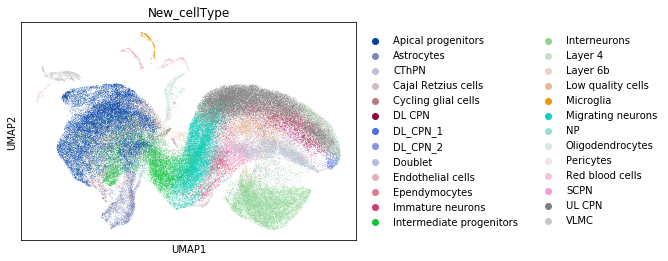

Use 25 PCs:


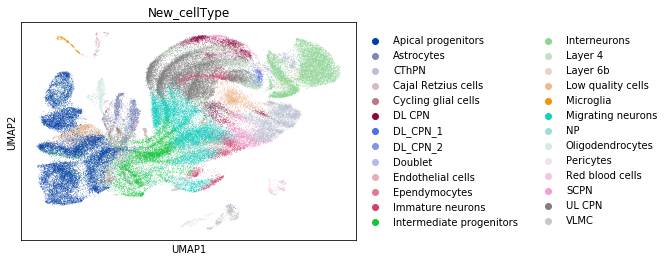

Use 50 PCs:


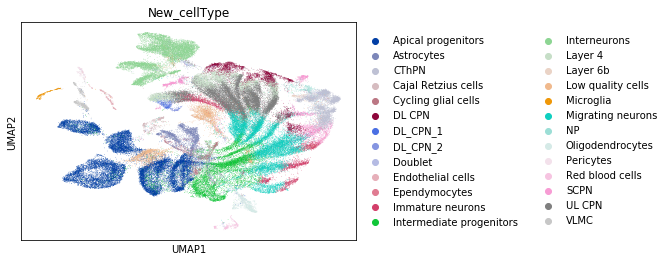

Use 100 PCs:


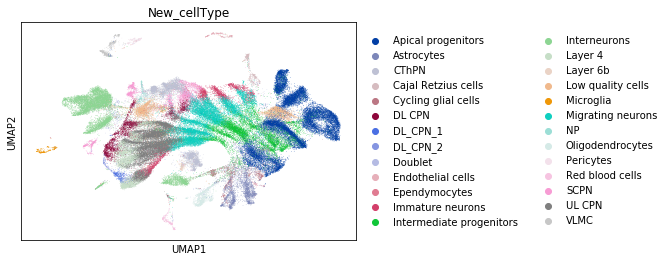

Use 200 PCs:


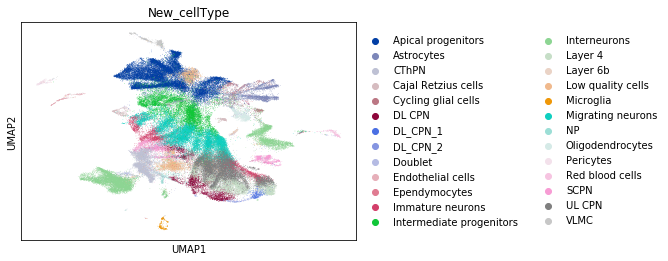

CPU times: user 48min 46s, sys: 37min 15s, total: 1h 26min 1s
Wall time: 6min 41s


In [6]:
%%time
# Test the effect of the number of PCs
# When the number of PCs is small, the fine structures of the data is not distinguishable.
# When the number of PCs is too high, the fine structures disappear again due to noises.
for n_pcs in [10, 25, 50, 100, 200]:
    print(f'Use {n_pcs} PCs:')
    sc.pl.umap(embed_umap(adata, n_pcs=n_pcs), color='New_cellType')

Determine the number of PCs to use by random shuffling.
	Random shuffle trial 0.
	Random shuffle trial 1.
	Random shuffle trial 2.
	Random shuffle trial 3.
	Random shuffle trial 4.
	Random shuffle trial 5.
	Random shuffle trial 6.
	Random shuffle trial 7.
	Random shuffle trial 8.
	Random shuffle trial 9.
Use 54 PCs.


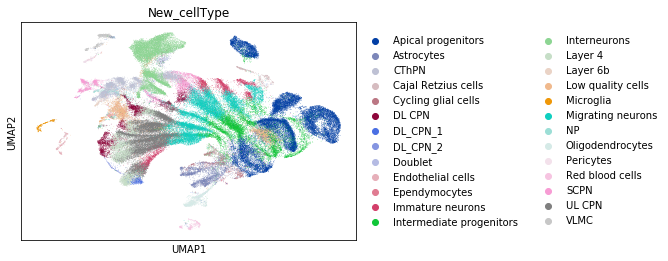

CPU times: user 2h 6min 57s, sys: 2h 7min 38s, total: 4h 14min 36s
Wall time: 13min 18s


In [7]:
%%time
# Determine the optimal number of PCs by randomly shuffling of gene expressions
sc.pl.umap(embed_umap(adata, n_pcs='auto'), color='New_cellType')

Use 5 neighbors:


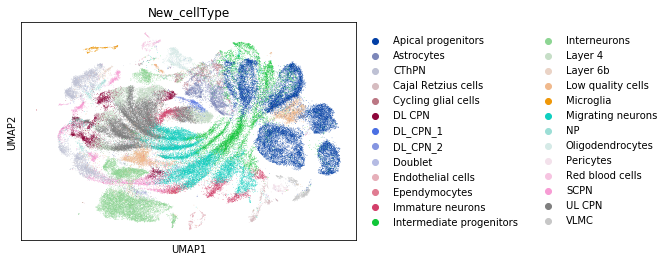

Use 10 neighbors:


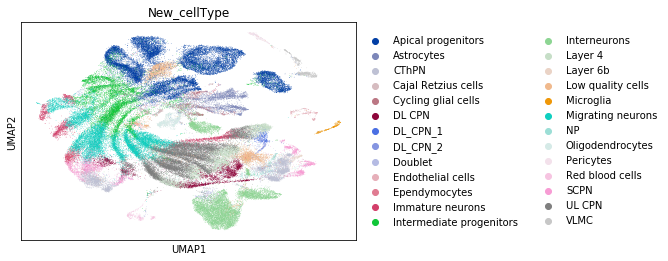

Use 15 neighbors:


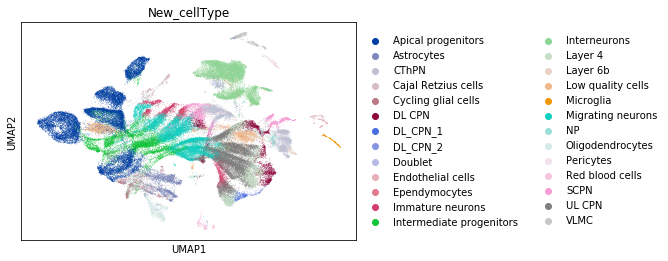

Use 25 neighbors:


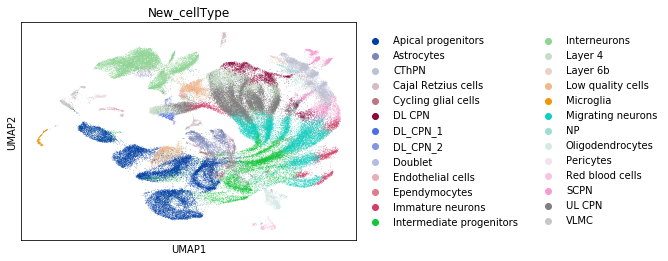

Use 50 neighbors:


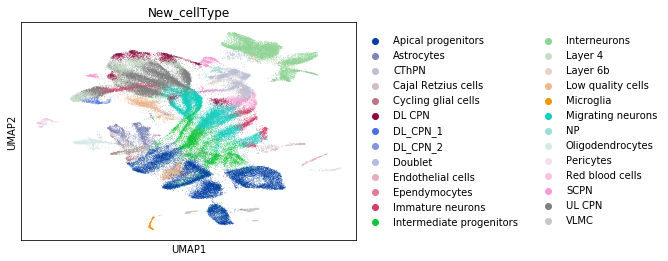

Use 100 neighbors:


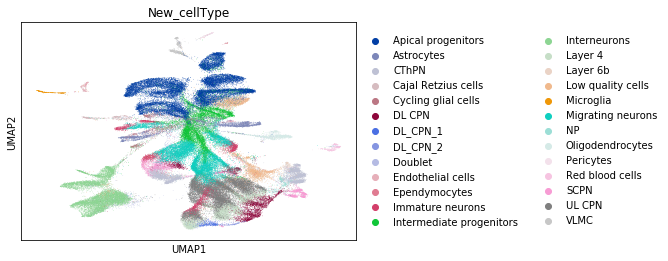

CPU times: user 58min 45s, sys: 36min 46s, total: 1h 35min 31s
Wall time: 9min


In [8]:
%%time
# Test the effect of the number of neighbors
# Lower numbers of neighbors tend to give more spreaded UMAP.
for n_neighbors in [5, 10, 15, 25, 50, 100]:
    print(f'Use {n_neighbors} neighbors:')
    sc.pl.umap(embed_umap(adata, n_pcs=54, n_neighbors=n_neighbors), color='New_cellType')

Use cosine metric:


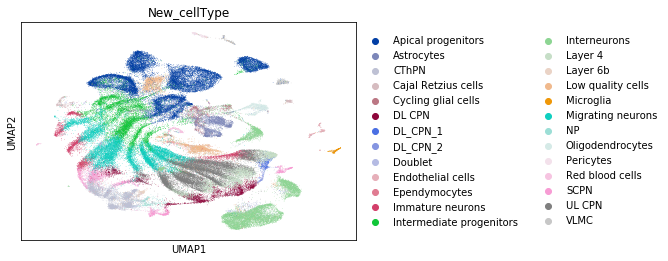

Use euclidean metric:


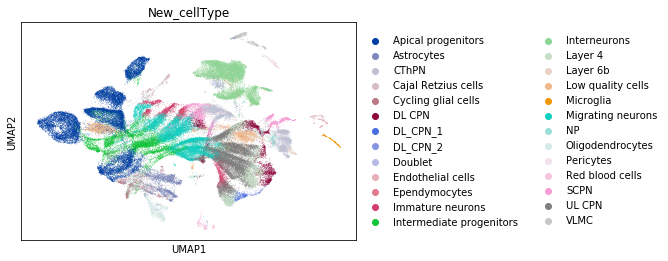

Use manhattan metric:


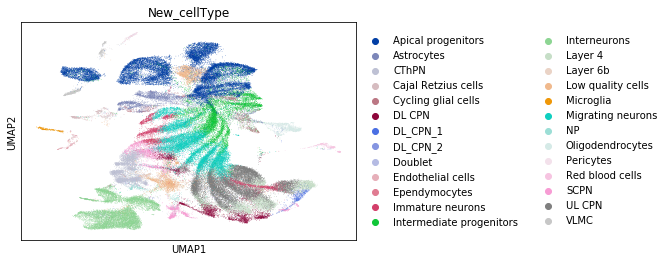

Use correlation metric:


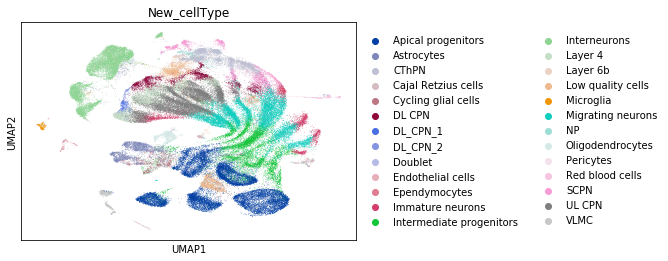

Use hamming metric:


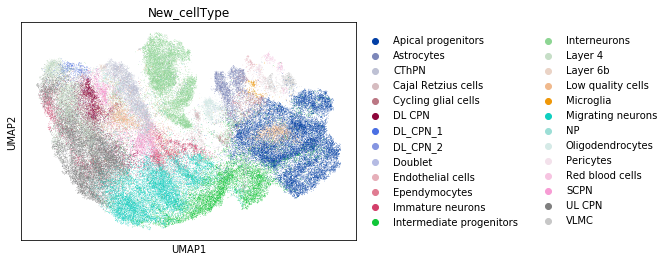

Use jaccard metric:


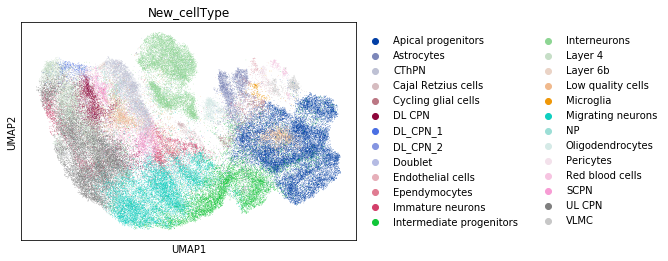

In [9]:
# Test the effect of the distance metrics
for metric in ['cosine', 'euclidean','manhattan', 'correlation', 'hamming', 'jaccard']:
    print(f'Use {metric} metric:')
    sc.pl.umap(embed_umap(adata, n_pcs=54, metric=metric), color='New_cellType')

Use 0.01 min_dist:


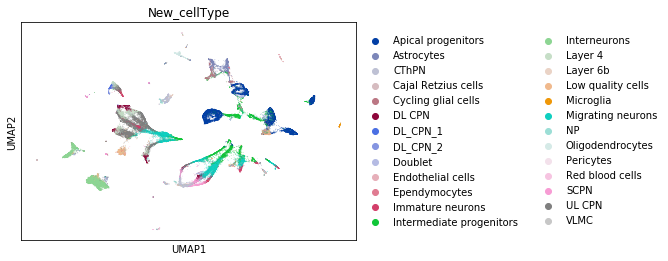

Use 0.1 min_dist:


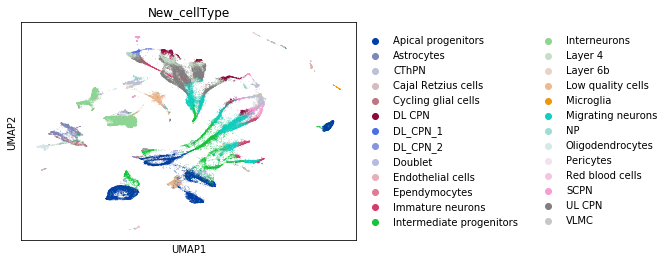

Use 0.2 min_dist:


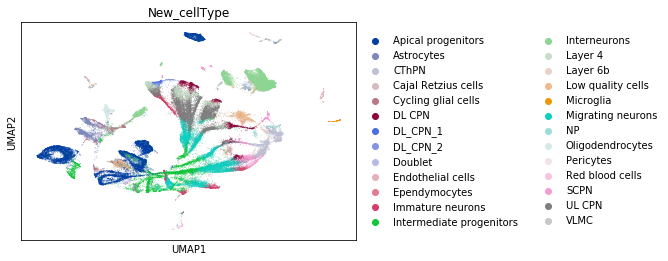

Use 0.5 min_dist:


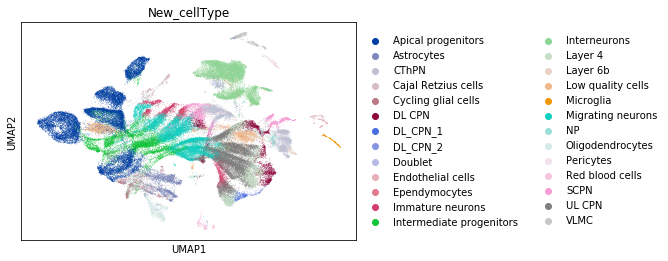

Use 0.8 min_dist:


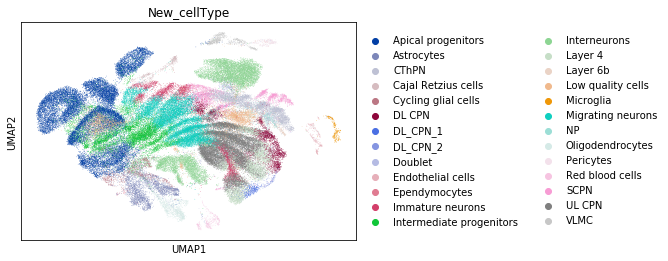

Use 1 min_dist:


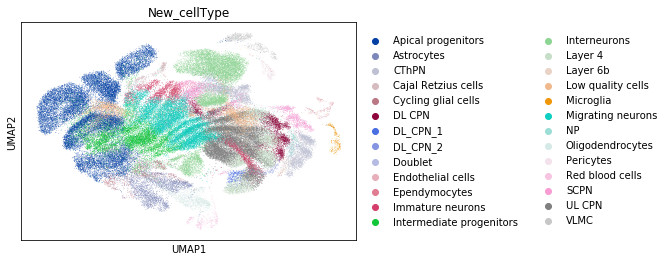

Use 1.5 min_dist:


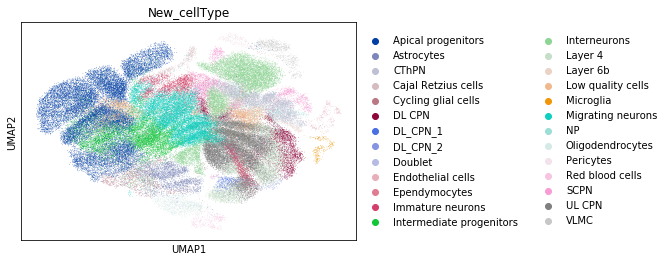

Use 2 min_dist:


/home/xingjie/.local/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


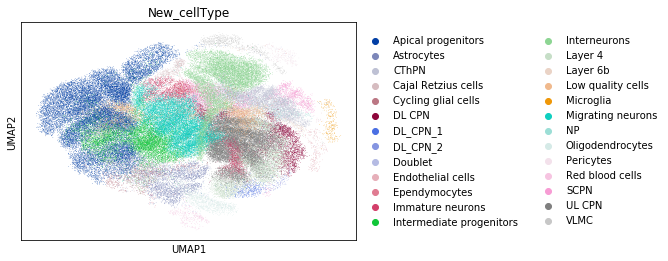

CPU times: user 1h 2min 37s, sys: 45min 10s, total: 1h 47min 48s
Wall time: 9min 30s


In [10]:
%%time
# Test the effect of the min_dist parameter of UMAP
# Larger min_dist gives greater spread.
for min_dist in [0.01, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2]:
    print(f'Use {min_dist} min_dist:')
    sc.pl.umap(embed_umap(adata, n_pcs=54, min_dist=min_dist), color='New_cellType')

Use 0.1 spread:


/home/xingjie/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


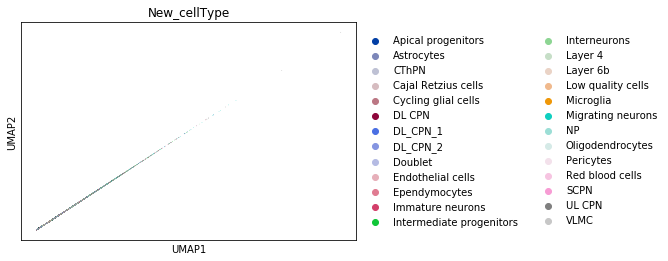

Use 0.5 spread:


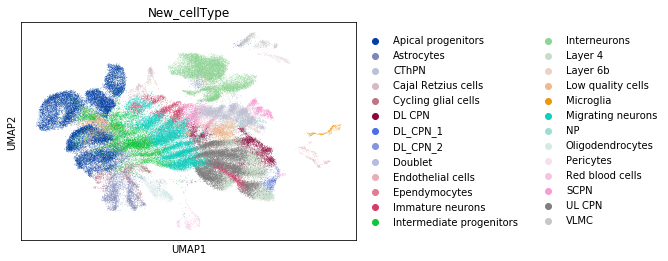

Use 1 spread:


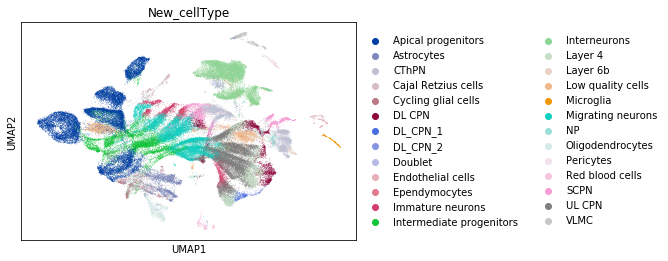

Use 2 spread:


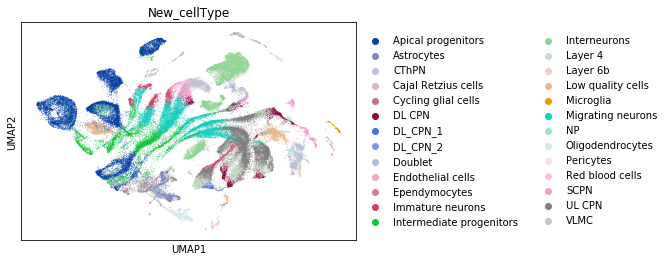

Use 5 spread:


/home/xingjie/.local/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


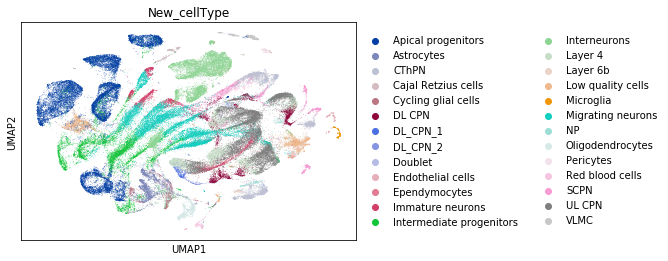

CPU times: user 39min 16s, sys: 28min 3s, total: 1h 7min 19s
Wall time: 5min 55s


In [11]:
%%time
# Test the effect of the spread parameter of UMAP
# Larger value of the spread parameter gives greater separation between clusters.
for spread in [0.1, 0.5, 1, 2, 5]:
    print(f'Use {spread} spread:')
    sc.pl.umap(embed_umap(adata, n_pcs=54, spread=spread), color='New_cellType')